In [1]:
#default_exp pv_forecast

# Charging with PV Forecast

Previously, we tried to produce a charge profile by constructing optimal charge profiles for each day, and then using these optimal charge profiles as targets in our models.

Here we will try and predict the optimal charge profile by first forecasting PV, then constructing an optimal profile based on the forecast. The hope is that estimating solar PV is easier than estimating optimal charge profiles, which tend to be pretty spiky and have given us weird residuals. 

### Imports

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from moepy.lowess import quantile_model

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from skopt.plots import plot_objective
from skopt.space import Real, Categorical, Integer

from batopt import clean, discharge, utils, charge

import FEAutils as hlp

### User inputs

In [3]:
raw_data_dir = '../data/raw'
intermediate_data_dir = '../data/intermediate'
cache_data_dir = '../data/nb-cache'
charge_opt_model_fp = '../models/charge_opt.sav'

### Preparing data

In [4]:
#exports
def prepare_training_input_data(intermediate_data_dir, start_hour=5):
    # Loading input data
    df = clean.combine_training_datasets(intermediate_data_dir).interpolate(limit=1)
    df_features = charge.construct_df_charge_features(df)
    
    # Filtering for overlapping feature and target data
    dt_idx = pd.date_range(df_features.index.min(), df['pv_power_mw'].dropna().index.max()-pd.Timedelta(minutes=30), freq='30T')

    s_pv = df.loc[dt_idx, 'pv_power_mw']
    df_features = df_features.loc[dt_idx]
        
    # Filtering for evening datetimes
    charging_datetimes = charge.extract_charging_datetimes(df_features, start_hour=start_hour)
    
    X = df_features.loc[charging_datetimes]
    y = s_pv.loc[charging_datetimes]
    
    return X, y

### Fitting forecast model

In [5]:
X, y = prepare_training_input_data(intermediate_data_dir)

In [6]:
df_pred = clean.generate_kfold_preds(X.values, y.values, RandomForestRegressor(), index=X.index)

Analysing residuals

Text(0, 0.5, 'Prediction')

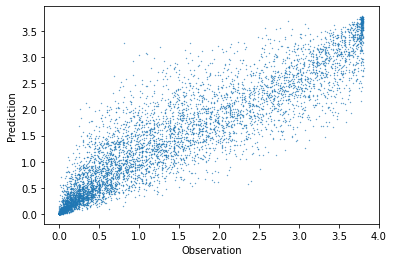

In [7]:
plt.scatter(df_pred.true, df_pred.pred, s=0.1)
plt.xlabel('Observation')
plt.ylabel('Prediction')

In [8]:
#exports
def plot_random_day(df_pred, ax=None):
    """
    View predicted and observed PV profiles
    """
    if ax is None:
        ax = plt.gca()
    
    random_day = pd.to_datetime(np.random.choice(df_pred.index.date))
    random_day = df_pred[df_pred.index.date==random_day]
    plt.plot(random_day.true)
    plt.plot(random_day.pred)
    
    return ax

<AxesSubplot:>

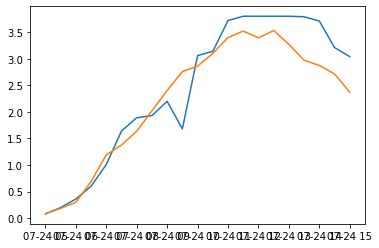

In [9]:
plot_random_day(df_pred)

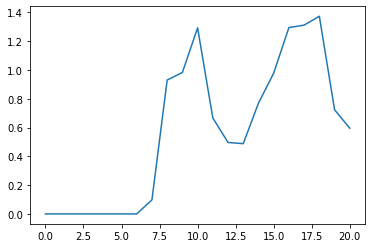

In [10]:
random_solar_profile = discharge.sample_random_day(df_pred.pred).pipe(charge.extract_solar_profile)
adj_random_solar_profile = discharge.flatten_peak(random_solar_profile)
charge_profile = charge.construct_charge_profile(random_solar_profile, adj_random_solar_profile)
plt.plot(charge_profile)

In [13]:
#exports
def generate_kfold_charge_preds(X, y, model, kfold_kwargs={'n_splits': 5, 'shuffle': True}):
    """
    Fit the PV forecasting model and calculate the optimal charge profile for predictions.
    """
    df_pred = clean.generate_kfold_preds(X.values, y.values, model, kfold_kwargs=kfold_kwargs, index=X.index)
    charge_pred = charge.construct_charge_s(df_pred.pred)
    charge_pred = charge.post_pred_charge_proc_func(charge_pred)
    return pd.DataFrame({'charge_pred': charge_pred, 
                         'pv_actual': df_pred.true,
                         'pv_pred': df_pred.pred})


In [21]:
#exports
def predict_charge(X, model):
    pv_pred = model.predict(X)
    charge_pred = charge.construct_charge_s(df_pred.pred)
    charge_pred = charge.post_pred_charge_proc_func(charge_pred)
    return pd.Series(charge_pred, index=X.index)

In [24]:
def get_train_test(arr, start_of_test_period): 
    train_arr = arr[:pd.to_datetime(start_of_test_period, utc=True)]
    test_arr = arr[pd.to_datetime(start_of_test_period, utc=True):]
    
    return train_arr, test_arr

start_of_test_period = '2018-09-15'

X_train, X_test = get_train_test(X, start_of_test_period)
y_train, y_test = get_train_test(y, start_of_test_period)

In [25]:
models = {
    'std_linear': LinearRegression(),
    'boosted': GradientBoostingRegressor(),
    'random_forest': RandomForestRegressor(),
}

for key in models:
    charge_pred_df = generate_kfold_charge_preds(X_train, y_train, models[key])
    score = charge.score_charging(charge_pred_df.charge_pred, charge_pred_df.pv_actual)
    pv_mse = np.mean(np.square(charge_pred_df.pv_actual - charge_pred_df.pv_pred))
    solar_exploit_pct = 100*charge.prop_max_solar(charge_pred_df.charge_pred, charge_pred_df.pv_actual)
    print("{}: PV MSE: {:.2f}, score: {:.2f}, solar exploit: {:.2f}%".format(key, pv_mse, score, solar_exploit_pct))

std_linear: PV MSE: 0.36, score: 0.83, solar exploit: 95.59%
boosted: PV MSE: 0.28, score: 0.83, solar exploit: 95.87%
random_forest: PV MSE: 0.20, score: 0.84, solar exploit: 96.76%


In [32]:
best_model = RandomForestRegressor()
best_model.fit(X_train, y_train)
preds = predict_charge(X_test, model)

In [33]:
100*charge.prop_max_solar(preds, y_test)

95.20990874864447

<br>

Finally we'll export the relevant code to our `batopt` module

In [ ]:
#hide
from nbdev.export import notebook2script
    
notebook2script()